# Data Analysis Report _ 2020.08.07

*By Xinyi Liu*


## Experiment


Description: **Singe-distance static-marker** experiment aiming to measure the magnitude of pose measurement noise when the camera hovers at around 1 meter away. To do it, go through the following few steps:

0. Place a single marker in the Blocks environment.

1. Run the ros-airsim simulation described in Dylan's documentation.

2. Import and process the collected data.

3. Using coordinate transformation to get the estimated UAV's trace in our ROS frame.

4. Compare it to the ground truth and measure the noise.


### Configurations
1. As shown in the two figures below, The marker center and the camera center are on a vertical line (having the same X and Y in **Absolute location**).


<img src="Figures/config1_08_06.png" width="600">
<img src="Figures/config2_08_06.png" width="600">

2. Joystick command (from *ROS/hiperlab_rostools/src/AirSim/airsim_hiperlab_link.py*):

  a. send start button sequence by **link.start_rates_controller()**

  b. sleep for enough time to have static measurement, here it is 30 sec: **rospy.sleep(30)**

  c. send landing command: **link.start_land_sequence()**
  
  
3. Change in *Documents/Airsim/settings.json*, make the camera recording facing down and transfer compressed images:

{
  "SettingsVersion": 1.2,
  "Recording": {
    "Cameras": [
        { "CameraName": "3", "ImageType": 0, "PixelsAsFloat": false, "Compress": true }
    ]
  }
}




4. Use marker 33 from *ROS/hiperlab_rostools/src/AirSim/aruco/markers/marker33.png*.

5. Place the marker 33 in the environment so that **marker coordinate axis positive direction = ros coordinate axis positive direction** (see section "Coordinate Transformation" for details)


## Import Data

We actually have 3 types of data streams here, 
1.  **rosData** from the ros simulator node. 
2. **airsimData** from the airsim-UE auto-documentation, has 8 entries: [time (s), pos_x (m), pos_y (m), pos_z (m), qw, qx, qy, qz].  
3. **arucoData** from the marker detection node, has 7 entries: [time (s), tvec_1 (m), tvec_2 (m), tvec_3 (m), rvec_1, rvec_2, rvec_3]. 

#### Tips: **rvec** and **tvec** meaning can be found here: 
a. https://docs.opencv.org/3.3.1/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d

b. http://rsewiki.elektro.dtu.dk/index.php/AruCo_Markers#Rotation_and_Translation


### Notes
1. Since **airsimData** basically records what have been published by **rosData** (with reversed y and z axises), so they should be both interpreted as *ground truth* (**GTData**). 

2. Notice that the **airsimData** has a lower sampling rate than **rosData** (around 3 Hz compared to 20 Hz) due to the transfer rate limitation of the airsim_hiperlab link, and the image-processing time is negligible compared to the time interval between two images. 

I choose **airsimData** as my **GTData**.

### See Fig.1 for the raw data demostration


In [1]:
from dataImport import *
arucoData = getArucoData("/home/xinyi/Documents/Repos/LabCode/GeneralCode-Dylan-eventBasedAirSim_gcc/Scripts/CompareArucoMocap/Logs/airsim_2020-08-08.txt")
GTData = getAirsimRecData("/home/xinyi/Documents/AirSim/2020-08-08-00-12-41/airsim_rec.txt")

## Coordinate Transformation ( convert into ROS simulator frame!)



Here we need a section, where input is the imported data, and output is specified to be camera's pose information from ground truth and from estimation of aruco marker. As there are different objects as well as different platform, different coordinate systems should be defined to solve the problem in a clear way. 

### Different Coordinate Systems

<img src="Figures/coordinate1.JPG" width="600">

#### reference:

a. https://docs.opencv.org/trunk/d5/dae/tutorial_aruco_detection.html

b. https://microsoft.github.io/AirSim/apis/

c. http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT9/node2.html

### Get Airsim Auto-docs Data (GTData) into ROS simulator frame

#### - UAV Pose in ROS simulator frame 
Add negative signs on pos_y,pos_z, qy,qz values respectively, we have the ground truth data of UAV pose represented in ROS simulator frame. 

#### - Camera Pose in ROS simulator frame
We know that for transformation between different frame, we have:

*camera's orientation in ros frame = UAV's orientation in ros frame · camera's orientation in UAV frame*

Between UAV frame and camera frame, here is a purely rotational transformation $R = [[0,-1,0],[-1,0,0],[0,0,1]]^{T}$(which is *camera's orientation in UAV frame*):



### Get Estimated Camera Pose in ROS simulator frame
In a nutshell, The function we use **aruco.estimatePoseSingleMarkers** returns transformation (defined by **rvec** and **tvec**) that transforms points from each **marker coordinate system** to the **camera coordinate system**. 
#### - Get Camera's Orientation in Marker's Frame
1. From **aruco.estimatePoseSingleMarkers** function, we retrives **rvec** and **tvec**, and we calculate the rotation matrix **rmat = cv2.Rodrigues(rvec)[0]**.

2. From spatial geometry, suppose the transformation from marker coordinate system to the camera coordinate system is $$g = (rmat, tvec)$$ that means for arbitrary point $P$ in space $R ^3$, its coordinate in camera frame can be decomposed as $$P^{camera} = rmat \cdot  P^{marker} + tvec$$ 
 so we got the reverse transformation by left multiplying each side by $rmat$, we get $$P^{marker} = rmat^{-1} \cdot P^{camera} - rmat^{-1} \cdot tvec = rmat^{T} \cdot P^{camera} - rmat^{T} \cdot tvec$$ which means $rmat^{T}$ can be seen as the basis of the camera frame represented by marker frame, which is simply the camera's orientation in marker's frame!



#### - Get Camera's Position in Marker's Frame


From the above derivation, let the arbitrary $P$ be the camera's projection center, we have $$P^{camera} = (0,0,0)$$ so the position of the camera in the frame of the aruco makrer ($P^{marker}$):  
 $$P^{marker} = - rmat^{T} \cdot tvec$$

##### reference: 
a. https://answers.opencv.org/question/161369/retrieve-yaw-pitch-roll-from-rvec/

b. https://docs.opencv.org/trunk/d9/d6a/group__aruco.html#ga84dd2e88f3e8c3255eb78e0f79571bd1


#### - Get Camera's Position & Orientation in ROS simulator Frame
Since the aruco marker is set to have the same direction as the ROS simulator's frame, so the Camera's orientation stays the same, while the position should substract the offset on z axis (height).

### Result Figures 
Fig.2 and Fig.3 shows the comparision of the estimated and the ground-truth camera pose in ros simulator frame . Observe that the transformation works well. However, we can see there are noise in the estimated pose. In the next section, noise on each component is modeled by white noise, and the standard deviation is given.

In [2]:
from coordinateTrans import *
#--------Estimation----------#
#get estimated camera pose in marker's frame
camPose_mkr = getEstCameraPose_mkr(arucoData) 
#get estimated camera pose in ros frame
camPose_ros = getEstCameraPose_ros(camPose_mkr)
#--------Ground Truth--------#
#get GT UAV pose in ros frame
GTUAVPose_ros = getGTUAVPose_ros(GTData)
# get GT camera pose in ros frame
GTCamPose_ros = getGTCamPose_ros(GTUAVPose_ros)



## Figures

In [3]:
from DrawData import *
print(np.mean(arucoData[-6:-1,3]))

0.7679888248100055


0.773335100201966


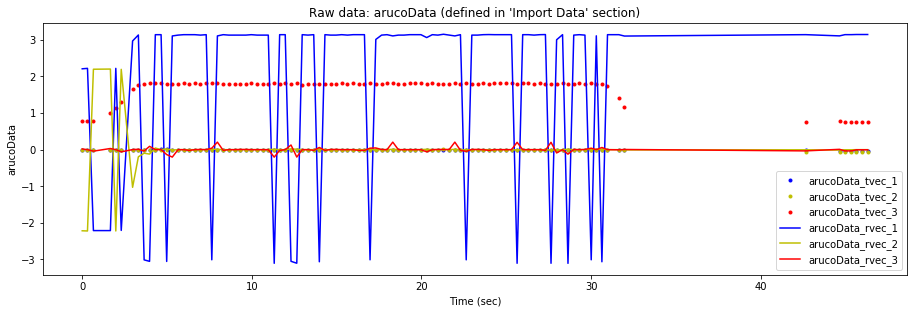

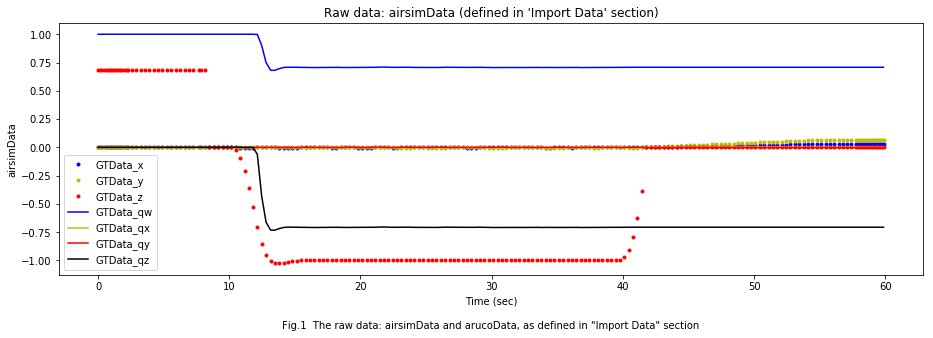

In [7]:
drawRawData(arucoData, GTData, fig_num=1,caption_txt='The raw data: airsimData and arucoData, as defined in "Import Data" section')
print(arucoData[0,3])

(10, 45)

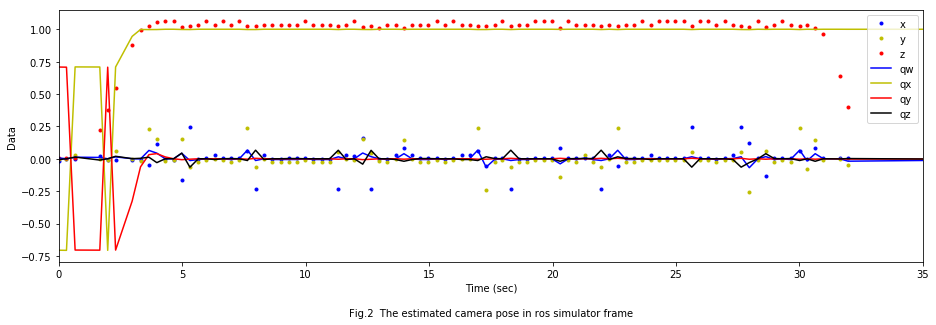

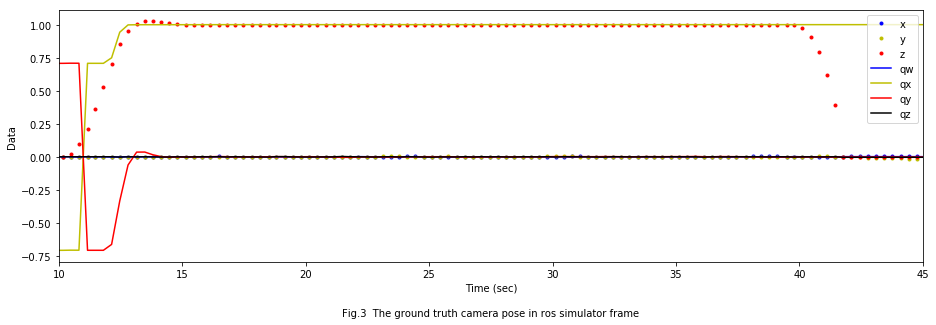

In [5]:
EstCamPose_ros = drawData8(camPose_ros,fig_num=2,caption_txt='The estimated camera pose in ros simulator frame') 
GTCamPose_ros= drawData8(GTCamPose_ros,fig_num=3,caption_txt='The ground truth camera pose in ros simulator frame')
EstCamPose_ros.set_xlim(0,35)
GTCamPose_ros.set_xlim(10,45)

## Noise Analysis

We analyse the time period when the UAV is hovering 1 meter higher than the starting point. We take 84 data points, and calculate the bias and standard deviation of each component. ( position unit is meter)

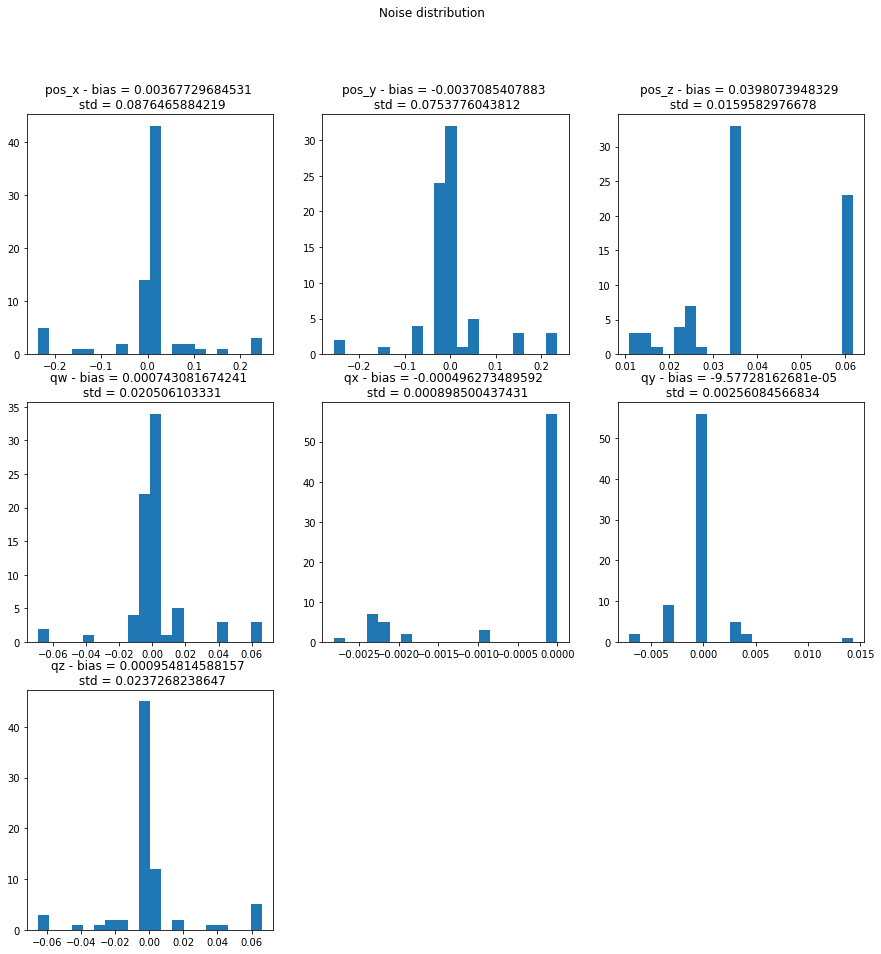

In [6]:
#take index 10-85
sl = camPose_ros[10:85,1:8].T
theory = np.array([0,0,1,0,1,0,0])
noise = np.zeros([7, sl.shape[1]])
bias, std = np.zeros(7),np.zeros(7)
for i in range(7):
    noise[i] = sl[i] - theory[i]
    std[i] = np.std(noise[i])
    bias[i] = np.mean(noise[i])
    

figPos = plt.figure(figsize=(15,15))
figPos.suptitle("Noise distribution")

name = ["pos_x","pos_y","pos_z","qw","qx","qy","qz"]
for i in range(7):
    axNo = i+1
    figPos.add_subplot(3, 3, axNo)
    figPos.axes[axNo-1].title.set_text("{} - bias = {} \n std = {}".format(name[i], bias[i], std[i]))
    #plt.xlim(-0.3,0.3)
    plt.hist(noise[i],bins=20)
